In [3]:
%matplotlib inline
import mpl_toolkits.mplot3d
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

import numpy as np
from numpy.linalg import cond, norm, inv

from scipy.spatial import cKDTree
import scipy.linalg as la
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve, lsqr
import scipy.sparse.linalg as spla
from scipy.optimize import minimize_scalar
from scipy.stats import linregress as linreg

import pandas as pd

import pickle
import os.path

import warnings
warnings.simplefilter('ignore')

from poly_basis import *

from ex2_helper import *

In [4]:
def foo_gauss(x, sigmas, ys):
    ret = 0
    for sigma, y in zip(sigmas,ys):
        r2 = dist(x,y)**2
        ret += sigma*np.exp(-sigma*r2) * (4+r2*(-2+(-4+r2)*sigma))
    return ret
    
def exact_gauss(x, sigmas, ys):
    ret = 0
    for sigma, y in zip(sigmas,ys):
        ret += np.exp(-sigma*dist(x,y)**2)
    return ret

# Parameters

In [44]:
file_name = 'largest_epsilon'

#node_sets = ['spiral', 'sym_t_design', 'min_energy', 'max_det', 'icos']
node_sets = ['spiral']
#node_sets = ['icos']
#node_sets = ['sym_t_design']
#node_sets = ['icos']
node_set_eps = [4.265276128679313, 4.2343765867243555, 3.6870560197899263, 4.065397822527591, 2.72936075936869]
node_set_eps = node_set_eps[:len(node_sets)]

ns = [400 * 2**i for i in range(0,6)]
#ns = [50, 170, 500]
print('ns:', ns)

#rbf_labels = ['r^3', 'r^4*log(r)', 'r^5', 'r^6*log(r)', 'r^7', 'r^8*log(r)', 'r^9', 'gaussian']
#rbf_labels = ['r^6*log(r)', 'r^7', 'r^8*log(r)', 'r^9']
#rbf_labels = ['r^3', 'r^5', 'r^9', 'gaussian']
#rbf_labels = ['gaussian']
#rbf_labels = ['r^9', 'gaussian']
rbf_labels = ['r^9']

#epsilons = [1, .5, .25, .1, .05]
#epsilons = [1, .05]
#epsilons = [.1, .01, .001]
epsilons = [2.72936075936869]
#epsilons = [4, 2, 1, .5, .25]

#basis_degs = [4] # -1 for no terms
basis_degs = range(0,5) # -1 for no terms
basis_types = ['s'] * len(basis_degs) # p for polynomial and s for spherical harmonics

'''
solution_index = 20

sol_deg = sphere_harm_degs[solution_index]
foo = lambda x: sphere_harm[solution_index](*x)*sol_deg*(sol_deg+1)
exact = lambda x: sphere_harm[solution_index](*x)
print('Harmonic degree: %d' % sphere_harm_degs[solution_index])
'''

#foo, exact = foo3, exact3

#gaussian foos
sigmas = [2, .5, .3, .1, 5, 2, 1.5]
ys = np.array([ [0,0,1],
                [1,-1,1],
                [2,0,1],
                [-5,7,0],
                [2,-13,1],
                [2,12,-15],
                [1,0,-1]], dtype=np.float)

assert len(ys) == len(sigmas)
#project ys onto sphere
for i, y in enumerate(ys):
    ys[i] = 1.0/norm(y)* y
foo = lambda x: foo_gauss(x, sigmas, ys)
exact = lambda x: exact_gauss(x, sigmas, ys)


#stencil_sizes = [7, 11, 31]
#stencil_sizes = [11, 23, 31]
#stencil_sizes = [50]
stencil_sizes = [31]
auto_choose_stencil = False
def choose_stencil_size(deg, minumum_size=11):
    return max(2*(deg+1)**2, minumum_size)

calculate_weights_cond = False
calculate_stencil_conds = True

optimize_epsilon = True
target_cond = 10**12
optimize_all_stencils = True

eps_by_nodeset = True # is overridden by optimize_epsilon

calc_largest_real_eig = True

notes = ''


if eps_by_nodeset: 
    assert len(node_set_eps) == len(node_sets)
print('%d trials to run' % (len(ns)*len(node_sets)*len(rbf_labels)*len(basis_degs)))

ns: [400, 800, 1600, 3200, 6400, 12800]
30 trials to run


# RBFs

In [45]:
rbf_dict = {}

even_tol = 1e-14

def rbf(r):
    return r**3
def d_phi_dr_div_r(r):
    return 3 * r
rbf_dict['r^3'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    if abs(r)< even_tol:
        return 0
    return r**4 * np.log(r)
def d_phi_dr_div_r(r):
    if abs(r)< even_tol:
        return 0
    return r**2 * (1 + 4*np.log(r))
rbf_dict['r^4*log(r)'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    return r**5
def d_phi_dr_div_r(r):
    return 5 * r**3
rbf_dict['r^5'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    if abs(r)< even_tol:
        return 0
    return r**6 * np.log(r)
def d_phi_dr_div_r(r):
    if abs(r)< even_tol:
        return 0
    return r**4 * (1 + 6*np.log(r))
rbf_dict['r^6*log(r)'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    return r**7
def d_phi_dr_div_r(r):
    return 7 * r**5
rbf_dict['r^7'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    if abs(r)< even_tol:
        return 0
    return r**8 * np.log(r)
def d_phi_dr_div_r(r):
    if abs(r)< even_tol:
        return 0
    return r**6 * (1 + 8*np.log(r))
rbf_dict['r^8*log(r)'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    return r**9
def d_phi_dr_div_r(r):
    return 9 * r**7
rbf_dict['r^9'] = (rbf, d_phi_dr_div_r)

# RBFs with Shape Parameter
shape_rbfs = []

def rbf(r):
    return np.exp(-(epsilon*r)**2)
def d_phi_dr_div_r(r):
    return -2 * epsilon**2 * np.exp(-(epsilon*r)**2)
rbf_dict['gaussian'] = (rbf, d_phi_dr_div_r)
shape_rbfs += ['gaussian']


def grad_rbf(node, node_center):
    r = dist(node, node_center)
    return d_phi_dr_div_r(r) * (np.array(node) - np.array(node_center))

def grad_rbf_outer(nodes, centers):
    n_len = len(nodes)
    c_len = len(centers)
    r = dist_outer(nodes, centers)[:,:,np.newaxis]
    xs = (np.array(nodes).reshape((1,n_len,3)) - np.array(centers).reshape((c_len,1,3)))
    return d_phi_dr_div_r(r) * xs

# Loops

In [46]:
columns = ['node_set', 'rbf',  'epsilon', 'basis_deg', 'basis_type', 'N', 'stencil_size', 
           'max_error', 'rel_L2_error']
data = pd.DataFrame(columns=columns)

assert len(basis_types) == len(basis_degs)
for node_set_index, node_set in enumerate(node_sets):
    #print(node_set + ' nodes')
    for n_try in ns:
        # generate nodes
        if node_set == 'spiral':
            n = n_try
            nodes = gen_spiral_nodes(n)
        elif node_set == 'sym_t_design':
            n, nodes = gen_symmetric_t_design_nodes(n_try)
        elif node_set == 'min_energy':
            n, nodes = gen_min_energy_nodes(n_try)
        elif node_set == 'max_det':
            n, nodes = gen_max_det_nodes(n_try)
        elif node_set == 'icos':
            n, nodes = gen_equ_area_icos_nodes(n_try)
        
        projectors = [np.eye(3) - np.outer(node, node) for node in nodes]
        avg_val = np.sum([exact(node) for node in nodes])
        print('%s nodes, n= %d' % (node_set,n))

        # generate stencils
        tree = cKDTree(np.array(nodes))
        

        # generate weights
        for rbf_label in rbf_labels:
            print('\trbf: ' + rbf_label)
            rbf, d_phi_dr_div_r = rbf_dict[rbf_label]
            skip_no_epsilon = False
            if optimize_epsilon:
                epsilons = [1]
            for epsilon in epsilons:
                eps_fallback = epsilon
                if skip_no_epsilon:
                    continue
                if rbf_label not in shape_rbfs:
                    skip_no_epsilon = True
                else:
                    if eps_by_nodeset:
                        epsilon = node_set_eps[node_set_index]
                        #print('\t\tepsilon changed to %f' % epsilon)
                    print('\t\tepsilon %f' % epsilon)
                
                for stencil_size in stencil_sizes:
                    if auto_choose_stencil:
                        if stencil_size != stencil_sizes[0]:
                            continue
                            # skip if doing more than one stencil size
                    if stencil_size > n:
                        stencil_size = n
                    
                    stencils = [tree.query(node, stencil_size)[1] for node in nodes]
                    print('\t\t\tstencil size: %d' % stencil_size)
                    
                    for basis_deg, basis_type in zip(basis_degs, basis_types):
                        if calculate_stencil_conds:
                            largest_stencil_cond = 0
                        else:
                            largest_stencil_cond = '-'
                            skeel = '-'
                        if auto_choose_stencil:
                            stencil_size = choose_stencil_size(basis_deg)
                            stencils = [tree.query(node, stencil_size)[1] for node in nodes]
                            
                        if stencil_size > n:
                            stencil_size = n
                            
                        if auto_choose_stencil:
                            print('\t\t\tstencil size changed: %d' % stencil_size)
                        
#begin inner loop
                        weights = np.zeros((n, stencil_size))
                        row_index = [r for r in range(n) for c in range(stencil_size)]
                        col_index = np.zeros((n, stencil_size))
                        for i, stencil in enumerate(stencils):

                            col_index[i] = stencil
                            nn = np.array([nodes[i] for i in stencil])
                            nn_proj = np.array([projectors[i] for i in stencil])
                            center_x, center_y, center_z = nn[0]
                            
                            if basis_type == 'p':
                                P, rhs_x, rhs_y, rhs_z = get_poly_basis(basis_deg, nn, nn_proj)
                            elif basis_type == 's':
                                P, rhs_x, rhs_y, rhs_z = gen_sphere_harm_basis(basis_deg, nn, nn_proj)
                            
                            if optimize_epsilon and (i==0 or optimize_all_stencils) and not skip_no_epsilon:
                                # optimize cond for first stencil
                                #dist_mat = np.array([[dist(node, node_center) 
                                #        for node in nn] for node_center in nn])
                                dist_mat = dist_outer(nn,nn)
                                
                                optimization_result = minimize_scalar(root_find, args=(dist_mat, P, target_cond))
                                epsilon = optimization_result['x']
                                # test if good
                                A = rbf(dist_outer(nn, nn))
                                num_basis = P.shape[1]
                                AP = np.block([[A,P],[P.T, np.zeros((num_basis,num_basis))]])
                                if cond(AP) > 10**16:
                                    optimization_result = minimize_scalar(root_find, 
                                                  bracket=[np.sqrt(n)/16/2, np.sqrt(n)/16*2],
                                                  args=(dist_mat, P, target_cond))
                                if optimization_result['success']:
                                    epsilon = optimization_result['x']
                                    eps_fallback = eps_fallback
                                else:
                                    epsilon = eps_fallback
                                if i==0:
                                    print(print('\t\tepsilon %f' % epsilon))

                            A = rbf(dist_outer(nn, nn))
                            #P = np.array([[1, x-center_x, y-center_y, z-center_z] for x,y,z in nn])
                            #P, rhs_x, rhs_y, rhs_z = get_poly_basis(basis_deg, nn, nn_proj)

                            num_basis = P.shape[1]

                            AP = np.block([[A,P],[P.T, np.zeros((num_basis,num_basis))]])
                            
                            if calculate_stencil_conds:
                                my_cond = cond(AP)
                                if i==0:
                                    skeel = skeel_cond(AP)
                                if my_cond > largest_stencil_cond:
                                    largest_stencil_cond = my_cond

                            #rhsAs = np.array([ [ nn_proj[j]@grad_rbf(node, node_center) 
                            #                    for j, node in enumerate(nn) ]
                            #                    for node_center in nn] )
                            #rhsAs = np.matmul(nn_proj, 
                            #               np.array([[grad_rbf(node, node_center) for node in nn] 
                            #               for node_center in nn]).reshape((50,50,3,1))).reshape((50,50,3))
                            rhsAs = np.matmul(nn_proj, 
                                              grad_rbf_outer(nn, nn).reshape(
                                                (stencil_size,stencil_size,3,1))).reshape(
                                                (stencil_size,stencil_size,3))
                            
                            singular_stencil = False
                            try:
                                rhsA = rhsAs[:,:,0] # only the x coordinates
                                rhs = np.block([[rhsA],
                                                [rhs_x]])
                                weights_grad = la.solve(AP, rhs)[:stencil_size,:].T
                                weights[i] = (weights_grad@weights_grad)[0]

                                rhsA = rhsAs[:,:,1] # only the y coordinates
                                rhs = np.block([[rhsA],
                                                [rhs_y]])
                                weights_grad = la.solve(AP, rhs)[:stencil_size,:].T
                                weights[i] += (weights_grad@weights_grad)[0]

                                rhsA = rhsAs[:,:,2] # only the z coordinates
                                rhs = np.block([[rhsA],
                                                [rhs_z]])
                                weights_grad = la.solve(AP, rhs)[:stencil_size,:].T
                                weights[i] += (weights_grad@weights_grad)[0]
                            except la.LinAlgError:
                                print('Singular stencil, skipping case.')
                                singular_stencil = True

                        if singular_stencil:
                            continue
                        C = sp.csc_matrix((weights.ravel(), (row_index, col_index.ravel())),shape=(n,n))

                        # solve steady-state
                        C = sp.vstack( [sp.hstack([C, np.ones((n,1))], format='csr'), 
                                        np.block([np.ones((1,n)), np.zeros((1,1))]) ], format='csr')
                        rhs = [-foo(node) for node in nodes] + [avg_val]
                        if calculate_weights_cond:
                            weights_cond = cond(C.todense())
                        else:
                            weights_cond = '-'
                        if calc_largest_real_eig:
                            try:
                                largest_real_eigenvalue = spla.eigs(C, k=1, which='LR')[0][0]
                            except spla.ArpackNoConvergence:
                                largest_real_eigenvalue = np.NaN
                        else:
                            largest_real_eigenvalue = '-'
                        
                        u = spsolve(C, rhs)
                        u = u[:-1]
                        u_true = np.array([exact(node) for node in nodes])
                        data = data.append( 
                            {'node_set': node_set, 'rbf':rbf_label, 'epsilon': epsilon,
                             'basis_deg':np.int(basis_deg), 'basis_type' : basis_type,
                             'N':n, 'stencil_size':stencil_size,
                             'max_error':np.max( np.abs(u-u_true ) ), 
                             'rel_L2_error':la.norm(u-u_true)/la.norm(u_true),
                             'stencil_cond': largest_stencil_cond, 
                             'skeel_cond' : skeel,
                             'weights_cond': weights_cond,
                             'target_cond' : target_cond,
                             'largest_re_eig': largest_real_eigenvalue}, ignore_index=True)


spiral nodes, n= 400
	rbf: r^9
			stencil size: 31
spiral nodes, n= 800
	rbf: r^9
			stencil size: 31
spiral nodes, n= 1600
	rbf: r^9
			stencil size: 31
spiral nodes, n= 3200
	rbf: r^9
			stencil size: 31
spiral nodes, n= 6400
	rbf: r^9
			stencil size: 31
spiral nodes, n= 12800
	rbf: r^9
			stencil size: 31


In [47]:
display(data[:10])

,node_set,rbf,epsilon,basis_deg,basis_type,N,stencil_size,max_error,rel_L2_error,largest_re_eig,skeel_cond,stencil_cond,target_cond,weights_cond
0,spiral,r^9,1,0,s,400,31,0.815737,0.100695,NaN,2.405759e+05,4.498485e+10,1.000000e+12,-
1,spiral,r^9,1,1,s,400,31,0.018575,0.003578,(20.000000000000064+0j),2.952575e+05,1.952060e+06,1.000000e+12,-
2,spiral,r^9,1,2,s,400,31,0.083748,0.007310,(709.1194912957786+0j),2.790667e+05,1.623946e+07,1.000000e+12,-
3,spiral,r^9,1,3,s,400,31,0.002979,0.000296,(20.000000000000007+0j),4.189027e+05,2.330335e+06,1.000000e+12,-
4,spiral,r^9,1,4,s,400,31,0.003300,0.000328,(20.000000000000025+0j),6.089942e+05,5.973643e+06,1.000000e+12,-
5,spiral,r^9,1,0,s,800,31,25.935671,2.974178,(3536.250641998632+0j),5.994467e+06,7.263247e+08,1.000000e+12,-
6,spiral,r^9,1,1,s,800,31,0.016245,0.002854,(28.284271247461938+0j),6.854431e+06,5.159030e+07,1.000000e+12,-
7,spiral,r^9,1,2,s,800,31,0.001513,0.000177,(28.28427124746198+0j),8.753154e+06,7.018496e+07,1.000000e+12,-
8,spiral,r^9,1,3,s,800,31,0.000686,0.000076,(28.28427124746197+0j),9.163802e+06,6.013061e+07,1.000000e+12,-
9,spiral,r^9,1,4,s,800,31,0.001557,0.000165,(28.284271247461934+0j),1.475900e+07,8.830135e+07,1.000000e+12,-


In [149]:
phs_data = read_data[read_data.rbf!='gaussian']

In [91]:
my_data = data

In [110]:
display(my_data)

,node_set,rbf,epsilon,basis_deg,basis_type,N,stencil_size,max_error,rel_L2_error,largest_re_eig,skeel_cond,stencil_cond,target_cond,weights_cond
0,spiral,gaussian,4.265276,-1,s,400,50,3.136836,0.599750,235.751091,-,-,1.000000e+12,-
1,spiral,gaussian,4.265276,-1,s,800,50,3.660251,0.621926,531.757438,-,-,1.000000e+12,-
2,spiral,gaussian,4.265276,-1,s,1600,50,0.145499,0.021181,1345.498242,-,-,1.000000e+12,-
3,spiral,gaussian,4.265276,-1,s,3200,50,0.030619,0.006703,2868.326889,-,-,1.000000e+12,-
4,spiral,gaussian,4.265276,-1,s,6400,50,0.004431,0.000959,NaN,-,-,1.000000e+12,-


In [49]:
display(eps_data)

,node_set,rbf,epsilon,basis_deg,basis_type,N,stencil_size,max_error,rel_L2_error,skeel_cond,stencil_cond,target_cond,weights_cond
0,spiral,gaussian,4.265276,-1,s,6400,50,0.008425,0.001816,-,-,1.000000e+12,-
0,sym_t_design,gaussian,4.234377,-1,s,6386,50,0.001290,0.000214,-,-,1.000000e+12,-
0,min_energy,gaussian,3.687056,-1,s,4666,50,0.000506,0.000125,-,-,1.000000e+12,-
0,max_det,gaussian,4.065398,-1,s,6400,50,0.000524,0.000123,-,-,1.000000e+12,-
0,icos,gaussian,2.729361,-1,s,2562,50,0.000289,0.000065,-,-,1.000000e+12,-


In [133]:
print(eps_data[eps_data.node_set=='icos'].epsilon[0])

2.72936075936869


In [140]:
data = my_data

In [60]:
display(data[:10])
display(read_data[:10])

,node_set,rbf,epsilon,basis_deg,basis_type,N,stencil_size,max_error,rel_L2_error,largest_re_eig,skeel_cond,stencil_cond,target_cond,weights_cond
0,spiral,gaussian,4.265276,-1,s,400,50,3.136836,0.599750,(22.043111319892585+0j),25.858148,1.900501e+02,1.000000e+12,-
1,spiral,gaussian,4.265276,0,s,400,50,0.423124,0.097418,(20.000000000000043+0j),66.872996,3.787712e+02,1.000000e+12,-
2,spiral,gaussian,4.265276,1,s,400,50,0.652823,0.132416,(20.000000000000085+0j),66.753858,3.814458e+02,1.000000e+12,-
3,spiral,gaussian,4.265276,2,s,400,50,0.082404,0.013220,(20.000000000000078+0j),88.072555,5.711332e+03,1.000000e+12,-
4,spiral,gaussian,4.265276,3,s,400,50,0.039215,0.006531,(20.000000000000046+0j),9485.980888,1.489774e+06,1.000000e+12,-
5,spiral,gaussian,4.265276,-1,s,800,50,3.660251,0.621926,(28.736512636939835+0j),1535.902188,3.335842e+04,1.000000e+12,-
6,spiral,gaussian,4.265276,0,s,800,50,0.101526,0.016089,(28.28427124746207+0j),3142.780458,4.697809e+04,1.000000e+12,-
7,spiral,gaussian,4.265276,1,s,800,50,0.143470,0.026254,(28.28427124746203+0j),3140.616233,4.555715e+04,1.000000e+12,-
8,spiral,gaussian,4.265276,2,s,800,50,0.023330,0.004164,(28.284271247461916+0j),3011.521539,4.558214e+04,1.000000e+12,-
9,spiral,gaussian,4.265276,3,s,800,50,0.017633,0.002489,(28.284271247461938+0j),16485.692304,1.247701e+07,1.000000e+12,-


,node_set,rbf,epsilon,basis_deg,basis_type,N,stencil_size,max_error,rel_L2_error,largest_re_eig,skeel_cond,stencil_cond,target_cond,weights_cond,label
0,spiral,r^9,2.729361,-1,s,400,50,0.222641,0.053221,(20.201926745482865+0j),6.277511e+05,2.008237e+07,1.000000e+12,-,r^9 2.72936075936869
1,spiral,r^9,2.729361,0,s,400,50,0.006746,0.001223,(20.00000000000003+0j),9.951886e+05,2.067941e+07,1.000000e+12,-,r^9 2.72936075936869
2,spiral,r^9,2.729361,1,s,400,50,0.002098,0.000321,(20.00000000000006+0j),1.029225e+06,2.099665e+07,1.000000e+12,-,r^9 2.72936075936869
3,spiral,r^9,2.729361,2,s,400,50,0.061796,0.005534,(97627.29659256009+0j),8.078985e+05,9.082821e+09,1.000000e+12,-,r^9 2.72936075936869
4,spiral,r^9,2.729361,3,s,400,50,0.002631,0.000317,(20.00000000000006+0j),1.001088e+06,2.101831e+07,1.000000e+12,-,r^9 2.72936075936869
5,spiral,r^9,2.729361,-1,s,800,50,0.491060,0.113182,(28.652530551861787+0j),6.385740e+05,4.067341e+07,1.000000e+12,-,r^9 2.72936075936869
6,spiral,r^9,2.729361,0,s,800,50,0.007739,0.001344,(28.284271247462016+0j),2.311147e+07,1.557191e+08,1.000000e+12,-,r^9 2.72936075936869
7,spiral,r^9,2.729361,1,s,800,50,0.000692,0.000082,(28.28427124746206+0j),2.504364e+07,1.627903e+08,1.000000e+12,-,r^9 2.72936075936869
8,spiral,r^9,2.729361,2,s,800,50,0.000625,0.000101,(28.284271247462065+0j),2.548113e+07,1.850372e+08,1.000000e+12,-,r^9 2.72936075936869
9,spiral,r^9,2.729361,3,s,800,50,0.000580,0.000074,(28.28427124746201+0j),2.554704e+07,1.887481e+08,1.000000e+12,-,r^9 2.72936075936869


In [58]:
my_data = pd.concat([read_data, data])

In [59]:
display(my_data)

,N,basis_deg,basis_type,epsilon,label,largest_re_eig,max_error,node_set,rbf,rel_L2_error,skeel_cond,stencil_cond,stencil_size,target_cond,weights_cond
0,400,-1,s,2.729361,r^9 2.72936075936869,(20.201926745482865+0j),2.226407e-01,spiral,r^9,5.322054e-02,6.277511e+05,2.008237e+07,50,1.000000e+12,-
1,400,0,s,2.729361,r^9 2.72936075936869,(20.00000000000003+0j),6.745954e-03,spiral,r^9,1.223059e-03,9.951886e+05,2.067941e+07,50,1.000000e+12,-
2,400,1,s,2.729361,r^9 2.72936075936869,(20.00000000000006+0j),2.098179e-03,spiral,r^9,3.205939e-04,1.029225e+06,2.099665e+07,50,1.000000e+12,-
3,400,2,s,2.729361,r^9 2.72936075936869,(97627.29659256009+0j),6.179576e-02,spiral,r^9,5.533702e-03,8.078985e+05,9.082821e+09,50,1.000000e+12,-
4,400,3,s,2.729361,r^9 2.72936075936869,(20.00000000000006+0j),2.631390e-03,spiral,r^9,3.170634e-04,1.001088e+06,2.101831e+07,50,1.000000e+12,-
5,800,-1,s,2.729361,r^9 2.72936075936869,(28.652530551861787+0j),4.910600e-01,spiral,r^9,1.131820e-01,6.385740e+05,4.067341e+07,50,1.000000e+12,-
6,800,0,s,2.729361,r^9 2.72936075936869,(28.284271247462016+0j),7.739000e-03,spiral,r^9,1.344445e-03,2.311147e+07,1.557191e+08,50,1.000000e+12,-
7,800,1,s,2.729361,r^9 2.72936075936869,(28.28427124746206+0j),6.922966e-04,spiral,r^9,8.200344e-05,2.504364e+07,1.627903e+08,50,1.000000e+12,-
8,800,2,s,2.729361,r^9 2.72936075936869,(28.284271247462065+0j),6.245828e-04,spiral,r^9,1.013944e-04,2.548113e+07,1.850372e+08,50,1.000000e+12,-
9,800,3,s,2.729361,r^9 2.72936075936869,(28.28427124746201+0j),5.798617e-04,spiral,r^9,7.408190e-05,2.554704e+07,1.887481e+08,50,1.000000e+12,-


In [150]:
display(phs_data[:10])

,node_set,rbf,epsilon,basis_deg,basis_type,N,stencil_size,max_error,rel_L2_error,skeel_cond,stencil_cond,target_cond,weights_cond,label
0,spiral,r^9,1,2,s,400,18,4.512917,0.706701,-,-,1.000000e+12,-,r^9 1
1,spiral,r^9,1,3,s,400,32,0.002662,0.000540,-,-,1.000000e+12,-,r^9 1
2,spiral,r^9,1,4,s,400,50,0.004678,0.000775,-,-,1.000000e+12,-,r^9 1
6,spiral,r^9,1,2,s,800,18,0.996335,0.110148,-,-,1.000000e+12,-,r^9 1
7,spiral,r^9,1,3,s,800,32,0.003122,0.000586,-,-,1.000000e+12,-,r^9 1
8,spiral,r^9,1,4,s,800,50,0.001353,0.000263,-,-,1.000000e+12,-,r^9 1
12,spiral,r^9,1,2,s,1600,18,0.369704,0.073780,-,-,1.000000e+12,-,r^9 1
13,spiral,r^9,1,3,s,1600,32,0.002138,0.000427,-,-,1.000000e+12,-,r^9 1
14,spiral,r^9,1,4,s,1600,50,0.000145,0.000026,-,-,1.000000e+12,-,r^9 1
18,spiral,r^9,1,2,s,3200,18,0.274926,0.033749,-,-,1.000000e+12,-,r^9 1


In [153]:
new_data = pd.concat([gaussian_data, phs_data])

In [155]:
read_data = new_data

In [169]:
data = read_data

# Write to File

In [61]:
i = 0
file_name_num = file_name + '_' + str(i) + '.pickle'
while os.path.isfile(os.path.join('pickles',file_name_num)):
    i += 1
    file_name_num = file_name + '_' + str(i) + '.pickle'

f = open(os.path.join('pickles',file_name_num), 'wb')
pickle.dump(data, f)
f.close()
print(file_name_num)

largest_epsilon_1.pickle


In [14]:
read_data = data

In [147]:
n_ticks = [n for i, (n,n1) in enumerate(zip(ns[:-1], ns[1:])) if n1/n > 1.4 or i==len(ns)-2]

# Read from File

In [56]:
file_to_read = 'largest_epsilon_r9_1.pickle'
f = open(os.path.join('pickles',file_to_read), 'rb')
read_data = pickle.load(f)
f.close()
read_data['N'] = read_data['N'].apply(pd.to_numeric, errors='coerce')
read_data['label'] = read_data['rbf'] + ' ' + read_data['epsilon'].astype(str)

rbf_labels = read_data.rbf.unique()
basis_degs = read_data.basis_deg.unique()
stencil_sizes = read_data.stencil_size.unique()
ns = read_data.N.unique()
ns.sort()
n_ticks = [n for i, (n,n1) in enumerate(zip(ns[:-1], ns[1:])) if n1/n > 1.4 or i==len(ns)-2]
epsilons = read_data.epsilon.unique()
#basis_degs = read_data.basis_deg.unique()

#read_data['sqrtN'] = np.sqrt(read_data['N'])

In [13]:
display(read_data.epsilon.unique()[0])

4.265276128679313

# Plots

In [73]:
display(data[:])

,node_set,rbf,epsilon,basis_deg,basis_type,N,stencil_size,max_error,rel_L2_error,largest_re_eig,skeel_cond,stencil_cond,target_cond,weights_cond
0,spiral,gaussian,4.265276,-1,s,400,50,3.136836e+00,5.997499e-01,(22.043111319892585+0j),2.585815e+01,1.900501e+02,1.000000e+12,-
1,spiral,gaussian,4.265276,0,s,400,50,4.231237e-01,9.741842e-02,(20.000000000000043+0j),6.687300e+01,3.787712e+02,1.000000e+12,-
2,spiral,gaussian,4.265276,1,s,400,50,6.528232e-01,1.324155e-01,(20.000000000000085+0j),6.675386e+01,3.814458e+02,1.000000e+12,-
3,spiral,gaussian,4.265276,2,s,400,50,8.240398e-02,1.321964e-02,(20.000000000000078+0j),8.807255e+01,5.711332e+03,1.000000e+12,-
4,spiral,gaussian,4.265276,3,s,400,50,3.921545e-02,6.531499e-03,(20.000000000000046+0j),9.485981e+03,1.489774e+06,1.000000e+12,-
5,spiral,gaussian,4.265276,-1,s,800,50,3.660251e+00,6.219259e-01,(28.736512636939835+0j),1.535902e+03,3.335842e+04,1.000000e+12,-
6,spiral,gaussian,4.265276,0,s,800,50,1.015259e-01,1.608910e-02,(28.28427124746207+0j),3.142780e+03,4.697809e+04,1.000000e+12,-
7,spiral,gaussian,4.265276,1,s,800,50,1.434702e-01,2.625418e-02,(28.28427124746203+0j),3.140616e+03,4.555715e+04,1.000000e+12,-
8,spiral,gaussian,4.265276,2,s,800,50,2.332972e-02,4.163963e-03,(28.284271247461916+0j),3.011522e+03,4.558214e+04,1.000000e+12,-
9,spiral,gaussian,4.265276,3,s,800,50,1.763324e-02,2.489061e-03,(28.284271247461938+0j),1.648569e+04,1.247701e+07,1.000000e+12,-


In [66]:
all_data.rbf.unique()

array(['gaussian'], dtype=object)

TypeError: 'AxesSubplot' object does not support indexing

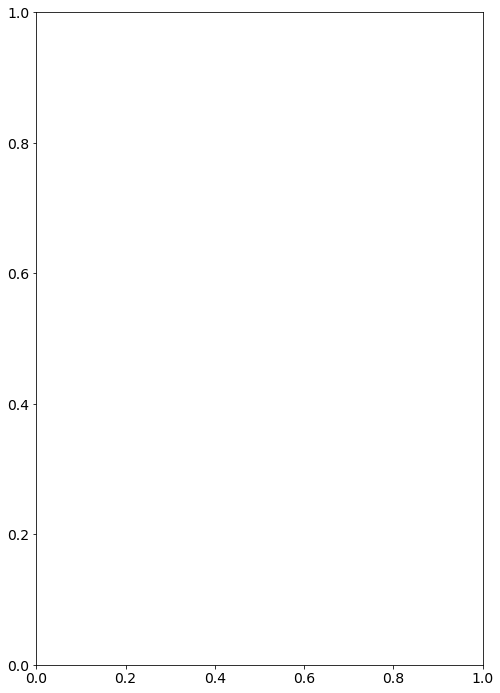

In [15]:
this_deg = 4
o_start = 0
o_end = -1

all_data = read_data#read_data[read_data.basis_deg==this_deg]

fig, ax_s = plt.subplots(len(all_data.rbf.unique()), sharex=True, figsize=(8,12))

for i, rbf in enumerate(all_data.rbf.unique()):
    legend = []
    read_data_slice = all_data[all_data.rbf==rbf]
    for node_set in read_data.node_set.unique():
        plot_data = read_data_slice[read_data_slice.node_set==node_set]
        #ax_s[i].loglog( 'N', 'rel_L2_error', data=plot_data, marker='o', linestyle='solid')
        ax_s[i].loglog( np.sqrt(plot_data.N.astype(np.float)), 
                       plot_data.rel_L2_error, marker='o', linestyle='dashed')
        ax_s[i].set_title(rbf + ' with deg ' + str(this_deg) + ' spherical harmonics')
        order = linreg(np.log(np.sqrt(plot_data.N[o_start:o_end].astype(np.float))), 
                       np.log(plot_data.rel_L2_error[o_start:o_end]))[0]
        legend += [node_set + ' ~ $\mathcal{O}(%.2f)$' %(-order)]
        ax_s[i].set_ylabel('Relative $L^2$ Error')
        ax_s[i].set_xticks(np.sqrt(n_ticks))
        #ax_s[i].set_xticklabels(['$\sqrt{%d}$' % n for n in n_ticks])
        ax_s[i].xaxis.set_tick_params(labelbottom=True)
    ax_s[i].legend( legend )
    
ax_s[-1].set_xlabel('$\sqrt{N}$')
plt.minorticks_off()
plt.xticks(np.sqrt(n_ticks), ['$\sqrt{%d}$' % n for n in n_ticks])
#plt.xlabel('$\sqrt{N}$')
#plt.ylabel('Relative $L^2$ Error')
#plt.title('Spherical Harmonics - Stencil size $31$')
plt.subplots_adjust(hspace=.2)
plt.show()

In [62]:
read_data = data

In [16]:
this_deg = 4
o_start = 0
o_end = -1

all_data = read_data[read_data.basis_deg==this_deg]

fig, ax_s = plt.subplots(len(all_data.rbf.unique()), sharex=True, figsize=(12,8))

#for i, rbf in enumerate(all_data.rbf.unique()):
legend = []
read_data_slice = all_data
for node_set in read_data.node_set.unique():
    plot_data = read_data_slice[read_data_slice.node_set==node_set]
    #ax_s[i].loglog( 'N', 'rel_L2_error', data=plot_data, marker='o', linestyle='solid')
    ax_s.loglog( np.sqrt(plot_data.N.astype(np.float)), 
                   plot_data.rel_L2_error, marker='o', linestyle='dashed')
    ax_s.set_title('Gaussians with $\\varepsilon$ optimized for largest N \nForcing is the sum of gaussians\nstencil size = 50')
    order = linreg(np.log(np.sqrt(plot_data.N[o_start:o_end].astype(np.float))), 
                   np.log(plot_data.rel_L2_error[o_start:o_end]))[0]
    legend += [node_set + ' ~ $\mathcal{O}(%.2f)$' %(-order)]
    ax_s.set_ylabel('Relative $L^2$ Error')
    ax_s.set_xticks(np.sqrt(n_ticks))
    #ax_s[i].set_xticklabels(['$\sqrt{%d}$' % n for n in n_ticks])
    ax_s.xaxis.set_tick_params(labelbottom=True)
ax_s.legend( legend )
    
ax_s.set_xlabel('$\sqrt{N}$')
plt.minorticks_off()
plt.xticks(np.sqrt(n_ticks), ['$\sqrt{%d}$' % n for n in n_ticks])
#plt.xlabel('$\sqrt{N}$')
#plt.ylabel('Relative $L^2$ Error')
#plt.title('Spherical Harmonics - Stencil size $31$')
plt.subplots_adjust(hspace=.2)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'loglog'

<Figure size 864x576 with 0 Axes>

In [78]:
ax_s

array([], dtype=object)

In [170]:
print(read_data.drop(columns=['basis_deg','basis_type','rbf','weights_cond', 'stencil_size']).to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>node_set</th>
      <th>epsilon</th>
      <th>N</th>
      <th>max_error</th>
      <th>rel_L2_error</th>
      <th>largest_re_eig</th>
      <th>skeel_cond</th>
      <th>stencil_cond</th>
      <th>target_cond</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>spiral</td>
      <td>4.265276</td>
      <td>400</td>
      <td>3.136836</td>
      <td>0.599750</td>
      <td>235.751091</td>
      <td>-</td>
      <td>-</td>
      <td>1.000000e+12</td>
    </tr>
    <tr>
      <th>1</th>
      <td>spiral</td>
      <td>4.265276</td>
      <td>800</td>
      <td>3.660251</td>
      <td>0.621926</td>
      <td>531.757438</td>
      <td>-</td>
      <td>-</td>
      <td>1.000000e+12</td>
    </tr>
    <tr>
      <th>2</th>
      <td>spiral</td>
      <td>4.265276</td>
      <td>1600</td>
      <td>0.145499</td>
      <td>0.021181</td>
      <td>1345.498242</td>
 

In [164]:
read_data.drop(columns=['basis_deg'])

,node_set,rbf,epsilon,basis_type,N,stencil_size,max_error,rel_L2_error,largest_re_eig,skeel_cond,stencil_cond,target_cond,weights_cond
0,spiral,gaussian,4.265276,s,400,50,3.136836,0.599750,235.751091,-,-,1.000000e+12,-
1,spiral,gaussian,4.265276,s,800,50,3.660251,0.621926,531.757438,-,-,1.000000e+12,-
2,spiral,gaussian,4.265276,s,1600,50,0.145499,0.021181,1345.498242,-,-,1.000000e+12,-
3,spiral,gaussian,4.265276,s,3200,50,0.030619,0.006703,2868.326889,-,-,1.000000e+12,-
4,spiral,gaussian,4.265276,s,6400,50,0.004431,0.000959,NaN,-,-,1.000000e+12,-
0,sym_t_design,gaussian,4.234377,s,393,50,4.830745,1.059085,243.052971,20.6389,309.971,1.000000e+12,-
1,sym_t_design,gaussian,4.234377,s,801,50,2.594560,0.590280,532.024430,983.245,43484,1.000000e+12,-
2,sym_t_design,gaussian,4.234377,s,1626,50,0.068025,0.013504,1223.179387,245625,1.90681e+07,1.000000e+12,-
3,sym_t_design,gaussian,4.234377,s,3201,50,0.008430,0.001750,2640.227298,8.43843e+07,1.99164e+10,1.000000e+12,-
4,sym_t_design,gaussian,4.234377,s,6386,50,0.000806,0.000139,6407.804086,2.81494e+10,2.44322e+13,1.000000e+12,-


In [163]:
display(read_data)

,node_set,rbf,epsilon,basis_deg,basis_type,N,stencil_size,max_error,rel_L2_error,largest_re_eig,skeel_cond,stencil_cond,target_cond,weights_cond
0,spiral,gaussian,4.265276,-1,s,400,50,3.136836,0.599750,235.751091,-,-,1.000000e+12,-
1,spiral,gaussian,4.265276,-1,s,800,50,3.660251,0.621926,531.757438,-,-,1.000000e+12,-
2,spiral,gaussian,4.265276,-1,s,1600,50,0.145499,0.021181,1345.498242,-,-,1.000000e+12,-
3,spiral,gaussian,4.265276,-1,s,3200,50,0.030619,0.006703,2868.326889,-,-,1.000000e+12,-
4,spiral,gaussian,4.265276,-1,s,6400,50,0.004431,0.000959,NaN,-,-,1.000000e+12,-
0,sym_t_design,gaussian,4.234377,-1,s,393,50,4.830745,1.059085,243.052971,20.6389,309.971,1.000000e+12,-
1,sym_t_design,gaussian,4.234377,-1,s,801,50,2.594560,0.590280,532.024430,983.245,43484,1.000000e+12,-
2,sym_t_design,gaussian,4.234377,-1,s,1626,50,0.068025,0.013504,1223.179387,245625,1.90681e+07,1.000000e+12,-
3,sym_t_design,gaussian,4.234377,-1,s,3201,50,0.008430,0.001750,2640.227298,8.43843e+07,1.99164e+10,1.000000e+12,-
4,sym_t_design,gaussian,4.234377,-1,s,6386,50,0.000806,0.000139,6407.804086,2.81494e+10,2.44322e+13,1.000000e+12,-


In [75]:
vals = spla.eigs(A,k=20)[0]

In [76]:
for v in vals:
    print(v)

(1.7127630750241094+5.109863575039694j)
(1.7127630750241094-5.109863575039694j)
(4.685328306071583+0.38939583185680826j)
(4.685328306071583-0.38939583185680826j)
(3.116819821011715+2.021487553457532j)
(3.116819821011715-2.021487553457532j)
(2.7077719465383296+0j)
(-0.6057915426417161+3.1988936942554105j)
(-0.6057915426417161-3.1988936942554105j)
(0.9718627792532022+1.7922885408987148j)
(0.9718627792532022-1.7922885408987148j)
(-3.5801324400953027+0.5003394081294109j)
(-3.5801324400953027-0.5003394081294109j)
(-2.556308902034842+0.8333597891153236j)
(-2.556308902034842-0.8333597891153236j)
(-2.6022614122122363+0j)
(-1.120845188056437+1.3978157698992213j)
(-1.120845188056437-1.3978157698992213j)
(-0.4232205594964544+0.47401895828895835j)
(-0.4232205594964544-0.47401895828895835j)


In [69]:
spla.eigs(A, k=1, which='LR')[0]

array([4.68532831-0.38939583j])

In [72]:
spla.eigs(A, k=1, which='SR')[0][0]

(-3.580132440095296+0.5003394081294107j)

In [71]:
np.real(spla.eigs(A, k=1, which='SR')[0][0])

-3.5801324400952925

In [24]:
display(read_data[:10])

,node_set,rbf,epsilon,basis_deg,basis_type,N,stencil_size,max_error,rel_L2_error,largest_re_eig,skeel_cond,stencil_cond,target_cond,weights_cond
0,spiral,r^9,1,1,s,400,31,0.018575,0.003578,(19.999999999999943+0j),2.952575e+05,1.952060e+06,1.000000e+12,-
1,spiral,r^9,1,2,s,400,31,0.083748,0.007310,(709.1194912957803+0j),2.790667e+05,1.623946e+07,1.000000e+12,-
2,spiral,r^9,1,3,s,400,31,0.002979,0.000296,(20.00000000000004+0j),4.189027e+05,2.330335e+06,1.000000e+12,-
3,spiral,r^9,1,1,s,800,31,0.016245,0.002854,(28.284271247462033+0j),6.854431e+06,5.159030e+07,1.000000e+12,-
4,spiral,r^9,1,2,s,800,31,0.001513,0.000177,(28.28427124746186+0j),8.753154e+06,7.018496e+07,1.000000e+12,-
5,spiral,r^9,1,3,s,800,31,0.000686,0.000076,(28.284271247461902+0j),9.163802e+06,6.013061e+07,1.000000e+12,-
6,spiral,r^9,1,1,s,1600,31,0.008590,0.001391,(39.99999999999999+0j),1.566609e+08,1.589990e+09,1.000000e+12,-
7,spiral,r^9,1,2,s,1600,31,0.000514,0.000109,(40.00000000000029+0j),1.698102e+08,1.818691e+09,1.000000e+12,-
8,spiral,r^9,1,3,s,1600,31,0.000292,0.000039,(40.000000000000114+0j),2.069083e+08,1.572987e+09,1.000000e+12,-
9,spiral,r^9,1,1,s,3200,31,0.018392,0.003155,(56.568542494923925+0j),3.561095e+09,3.182975e+10,1.000000e+12,-


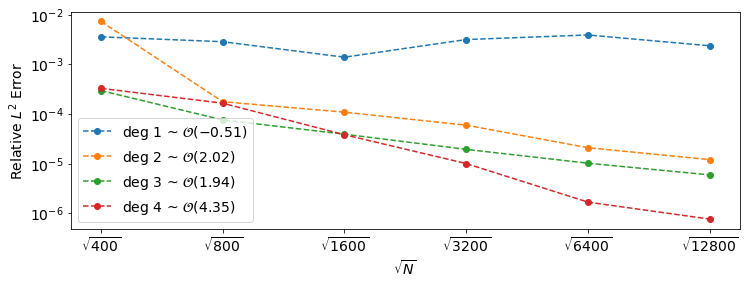

In [49]:
read_data = data

o_start, o_end = 1, 5
n_ticks = [n for i, (n,n1) in enumerate(zip(ns[:-1], ns[1:])) if n1/n > 1.4 or i==len(ns)-2]

fig = plt.figure(figsize=(12,4))

#for i, rbf in enumerate(all_data.rbf.unique()):
legend = []
for deg in range(1,5):
    plot_data = read_data[read_data.basis_deg==deg]
    #ax_s[i].loglog( 'N', 'rel_L2_error', data=plot_data, marker='o', linestyle='solid')
    plt.loglog( np.sqrt(plot_data.N.astype(np.float)), 
                   plot_data.rel_L2_error, marker='o', linestyle='dashed')
    order = linreg(np.log(np.sqrt(plot_data.N.astype(np.float)[o_start:o_end])), 
                   np.log(plot_data.rel_L2_error[o_start:o_end]))[0]
    legend += ['deg %d ~ $\mathcal{O}(%.2f)$' %(deg, -order)]
    plt.ylabel('Relative $L^2$ Error')
    #plt.xticks(np.sqrt(n_ticks))
    #ax_s[i].set_xticklabels(['$\sqrt{%d}$' % n for n in n_ticks])
    #plt.xaxis.set_tick_params(labelbottom=True)
plt.legend( legend )
    
plt.minorticks_off()
plt.xticks(np.sqrt(ns), ['$\sqrt{%d}$' % n for n in ns])
plt.xlabel('$\sqrt{N}$')
#plt.ylabel('Relative $L^2$ Error')
#plt.title('Spherical Harmonics - Stencil size $31$')
# plt.subplots_adjust(hspace=.2)
plt.show()

In [56]:
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

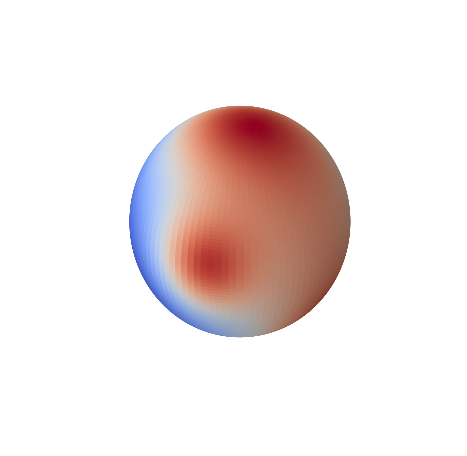

In [61]:
n = 100

u = np.linspace(0, 2 * np.pi, n)
v = np.linspace(0, np.pi, n)
X = np.outer(np.cos(u), np.sin(v))
Y = np.outer(np.sin(u), np.sin(v))
Z = np.outer(np.ones(np.size(u)), np.cos(v))

val = np.array([ exact((x,y,z)) for x,y,z in zip(X,Y,Z)])

# fourth dimention - colormap
# create colormap according to x-value (can use any 50x50 array)
color_dimension = val # change to desired fourth dimension
minn, maxx = color_dimension.min(), color_dimension.max()
norm = matplotlib.colors.Normalize(minn, maxx)
m = plt.cm.ScalarMappable(norm=norm, cmap='coolwarm')
m.set_array([])
fcolors = m.to_rgba(color_dimension)

# plot

fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
line = ax.plot_surface(X,Y,Z,
                       rstride=1, cstride=1, facecolors=fcolors,
                       vmin=minn, vmax=maxx, shade=True)

plt.axis('off')
ax.grid(False)